<a href="https://www.kaggle.com/code/jennifermohr/evaluation-of-team-tackle-yards-saved-using-ml?scriptVersionId=158212155" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


#### **By [Jennifer Mohr](https://jennmohr.github.io/)**


## Introduction
#### **Track:** Coaching Presentation Track

In the fast-paced realm of NFL football, where every yard gained or lost can be the difference between victory and defeat, evaluating defensive performance becomes paramount. The primary goal of this project is to delve into the intricacies of a team's defensive capabilities, measured through the lens of **"Yards Saved Above Expected"** and the consequential yards allowed due to missed tackles. By analyzing these metrics, the data aims to provide coaches and teams with a comprehensive understanding of their defensive strengths and weaknesses, ultimately offering valuable awareness into the plays that shape the outcome of a game.

Once the ball is snapped and in play, the defense's mission is clear: minimize the yardage gained by the opposing team. A single well-executed tackle or, conversely, a missed tackle, can be a game-changer. The significance of these moments cannot be overstated; a successful tackle can prevent a potential scoring play, while a failed one might allow the offense to seize a crucial advantage. In this context, effective tackle performance emerges as a pivotal indicator of a team's overall defensive prowess.To achieve these insights, a sophisticated approach was employed, utilizing a histogram-based gradient boosting regression tree. This machine learning model is trained on data from weeks 1 to 8, incorporating essential factors from each play. Subsequently, the model is applied to week 9 data, enabling a comprehensive evaluation of team performances during this pivotal period.

In the following sections, I will delve into the methodology, present key findings, and illuminate plays of significant impact. These analyses strive to empower teams and coaches with actionable information, fostering a deeper understanding of their defensive strategies and setting the stage for continuous improvement.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

## Data Preparation

In the pursuit of assessing defensive performance in the NFL, it was necessary to clean up the data and assess with a meticulous eye regarding what exactly should be evaluated. The key features in the data that were considered are as follows:
* **Tracking Data**: gameId, playId, nflId, frameId, playDirection, x, y, event
* **Game Data**: gameId, week, homeTeamAbbr, visitorTeamAbbr
* **Play Data**: gameId, playId, ballCarrierId, yardsToGo, defensiveTeam, passResult, playResult, playNullifiedByPenalty, offenseFormation, defendersInTheBox
* **Player Data**: nflId, displayName
* **Tackles Data**: gameId, playId, nflId, tackle, assist, forcedFumble, pff_missedTackle

As mentioned in the introduction, the data was split into two subsets: data from Weeks 1-8 and data from Week 9. Data from Weeks 1-8 was used to train the ML model used. The model was then applied to Week 9 to generate insights.

In [2]:
tracking_data = pd.DataFrame()

for week in range(1, 10):
    file_path = f'../input/nfl-big-data-bowl-2024/tracking_week_{week}.csv'  
    week_data = pd.read_csv(file_path)
    tracking_data = pd.concat([tracking_data, week_data], ignore_index=True)
    raw_tracking_data = pd.concat([tracking_data, week_data], ignore_index=True)
    
tracking_data = tracking_data.drop(columns=["displayName", "frameId", "time", "jerseyNumber", "playDirection", "s", "a", "dis","o","dir" ])
tracking_data = tracking_data[(tracking_data['club'] != 'football')]
tracking_data = tracking_data[(tracking_data['event'] == 'pass_outcome_caught') | (tracking_data['event'] == 'handoff') | (tracking_data['event'] == 'run') | (tracking_data['event'] == 'lateral') | (tracking_data['event'] == 'pass_shovel') | (tracking_data['event'] == 'snap_direct')]

In [3]:
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2024/plays.csv')
games_df = pd.read_csv('../input/nfl-big-data-bowl-2024/games.csv')
tackles_df = pd.read_csv('../input/nfl-big-data-bowl-2024/tackles.csv')
players_df = pd.read_csv('../input/nfl-big-data-bowl-2024/players.csv')
raw_plays_df = pd.read_csv('../input/nfl-big-data-bowl-2024/plays.csv')

plays_df = plays_df.drop(columns=["quarter", "down", "gameClock", "yardlineSide", "yardlineNumber", "ballCarrierDisplayName", "penaltyYards", "preSnapHomeScore", "passProbability", "preSnapVisitorScore","absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "preSnapVisitorTeamWinProbability", "homeTeamWinProbabilityAdded", "visitorTeamWinProbilityAdded", "expectedPoints", "expectedPointsAdded", "foulName1", "foulName2", "foulNFLId1", "foulNFLId2"])
plays_df = plays_df[(plays_df['playNullifiedByPenalty'] == 'N')]
plays_df["passResult"] = plays_df["passResult"].fillna("RUN")

games_df = games_df.drop(columns=["season", "gameDate", "gameTimeEastern", "homeFinalScore", "visitorFinalScore"])

In [4]:
week_1_to_8_gameIds = games_df[games_df['week'].isin(range(1, 9))]['gameId']
week_9_gameIds = games_df[games_df['week'] == 9]['gameId']

In [5]:
game_tackles_df = pd.merge(plays_df, tackles_df, on=['gameId', 'playId'])
game_tackles_df = game_tackles_df[((game_tackles_df['tackle'] == 1) | (game_tackles_df['assist'] == 1))]

### Custom Data Insight: DistanceFromClosestDefender
One important factor when it comes to tackling is how close a defender is to the ball carrier. If the ball is thrown down the field and there is no defender within 5 yards of the receiver, the receiver will typically gain more yards than they would if the defender was running alongside the receiver, just half a yard away. Since this data was not provided alongside the tracking data, it was important to quantify the proximity of the ball carrier to the nearest defender at the moment the ball is in play and no longer with the quarterback (unless in the case of a QB scramble).

The distance metric serves as a crucial input for our machine learning model, capturing the effectiveness of defensive positioning in relation to typical yards gained during a play. The provided **getDistance** function takes the x and y coordinates of two player positions on the field - one representing the ball carrier and the other a defender, and calculates the Euclidean distance between them using the Pythagorean theorem.

The **getClosestDefender** function is applied to each tackle row in the data. It identifies the home and visitor team in order to not take in account offensive players proximities to the ball carrier. The function then selects the position data for all defensive players on that same play and calculates the distance to the ball carrier using the getDistance function outlined above. The minimum distance among all defenders is determined and returned as the result. This value is then used in the model to help evaluate the effectiveness of the tackles that are occurring. 

In [6]:
def getDistance(player_x, player_y, ball_carrier_x, ball_carrier_y):
    return ((player_x - ball_carrier_x) ** 2 + (player_y - ball_carrier_y) ** 2) ** 0.5

def getClosestDefender(row):
    selected_game = games_df[games_df['gameId'] == row['gameId']].values[0]
    game_tracking_df = tracking_data[tracking_data['gameId'] == row['gameId']]
    
    homeTeam = selected_game[2]
    visitorTeam = selected_game[3]
    
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    ball_in_hand_play_df = game_tracking_df[(game_tracking_df['nflId'] == ballCarrierId) & (game_tracking_df['playId'] == playId)]
    if len(ball_in_hand_play_df['club'].values) > 0:
        ballCarrierClub = ball_in_hand_play_df['club'].values[0]
        
        if ballCarrierClub == homeTeam:
            opponent_club = visitorTeam
        else:
            opponent_club = homeTeam

        other_players_position_df = game_tracking_df[(game_tracking_df['nflId'] != ballCarrierId) & (game_tracking_df['playId'] == playId) & (game_tracking_df['club'] == opponent_club)]
    
        if not ball_in_hand_play_df.empty:
            ball_carrier_x = ball_in_hand_play_df['x'].values[0]
            ball_carrier_y = ball_in_hand_play_df['y'].values[0]

            other_players_position_df['distance_to_ball_carrier'] = getDistance(other_players_position_df['x'], other_players_position_df['y'], ball_carrier_x, ball_carrier_y)
            min_distance = other_players_position_df['distance_to_ball_carrier'].min()

            return min_distance
    else:
        return 'NaN'
    
    
game_tackles_df['distanceFromClosestDefender'] = game_tackles_df.apply(getClosestDefender, axis=1)

In [7]:
game_tackles_df = game_tackles_df.dropna(subset=['distanceFromClosestDefender'])
game_tackles_df = game_tackles_df.drop(columns=['possessionTeam', 'passLength', 'playNullifiedByPenalty'])

## Using ML To Calculate 'yardsSavedAboveExpected'

### Variables Used in the Model
* **offenseFormation**: Formation used by the possession team, transformed into a numerical representation using a LabelEncoder
* **passResult**: Dropback outcome of the play, all NA values were treated as run plays, transformed into a numerical representation using a LabelEncoder
* **defendersInTheBox**: Number of defenders in close proximinity to line-of-scrimmage
* **yardsToGo**: Distance needed for a first down
* **distanceFromClosestDefender**: Metric calculated to represent the proximity of the ball carrier to the nearest defender at the moment the ball is in play
* **prePenaltyPlayResult**: Net yards gained by the offense, before penalty yardage

### Histogram-Based Gradient Boosting Regressor
The choice of using a Histogram-Based Gradient Boosting Regressor for this specific use case was due to the following factors:
* **Robustness to Outliers**
    * Gradient Boosting models, in general, are known for their robustness to outliers. The ensemble nature of boosting helps in reducing the impact of individual data points that might have extreme values, making the model more resilient to noisy data.
* **Non-Linear Relationships**
    * A histogram-based approach is well-suited for capturing non-linear relationships within the data. In the context of NFL tackle performance, where the impact of various factors on play outcomes may not follow a linear pattern, a non-linear model can better capiture the complexities of the relationships.
* **Predicting Continuous Outputs**
    * Since the task involves predicting yards gained on tackling plays, which is a continuous variable, a regression model is appropriate. Gradient Boosting Regressors excelt at predicting continuous outputs.
* **Consistent Model Performance**
    * Gradient Boosting models, including the histogram-based variant, often exhibit stable and reliable performance across different types of datasets. This consistency is valuable for generating reliable insights in a sports analytics context.


In [8]:
le = LabelEncoder()

game_tackles_df['offenseFormation_idx'] = le.fit_transform(game_tackles_df['offenseFormation'])
game_tackles_df['playType_idx'] = le.fit_transform(game_tackles_df['passResult'])

mean_value = game_tackles_df['defendersInTheBox'].mean()
game_tackles_df.loc[game_tackles_df['defendersInTheBox'].isna(), 'defendersInTheBox'] = mean_value

weeks_1_to_8_tackles_df = game_tackles_df[game_tackles_df['gameId'].isin(week_1_to_8_gameIds)]
week_9_tackles_df = game_tackles_df[game_tackles_df['gameId'].isin(week_9_gameIds)]

X_train = weeks_1_to_8_tackles_df[['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']]
y_train = weeks_1_to_8_tackles_df['prePenaltyPlayResult']

X_test = week_9_tackles_df[['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']]
y_test = week_9_tackles_df['prePenaltyPlayResult']

X_train.loc[X_train['defendersInTheBox'].isna(), 'defendersInTheBox'] = X_train['defendersInTheBox'].mean()
X_test.loc[X_test['defendersInTheBox'].isna(), 'defendersInTheBox'] = X_test['defendersInTheBox'].mean()

In [9]:
regr = HistGradientBoostingRegressor()

regr.fit(X_train, y_train)

def getExpectedYards(row, regr):
    columns = ['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']
    data = row[columns].values.reshape(1, -1)
    df = pd.DataFrame(data, columns=columns)
    
    return round(regr.predict(df)[0], 2)

week_9_tackles_df = week_9_tackles_df.copy()

week_9_tackles_df.loc[:, 'expectedYards'] = week_9_tackles_df.apply(getExpectedYards, axis=1, regr=regr)
week_9_tackles_df.loc[:, 'yardsSavedAboveExpected'] = week_9_tackles_df['expectedYards'] - week_9_tackles_df['playResult']
week_9_tackles_df.loc[:, 'yardsSavedAboveExpected'] = week_9_tackles_df['yardsSavedAboveExpected'].apply(lambda x: max(0, x))

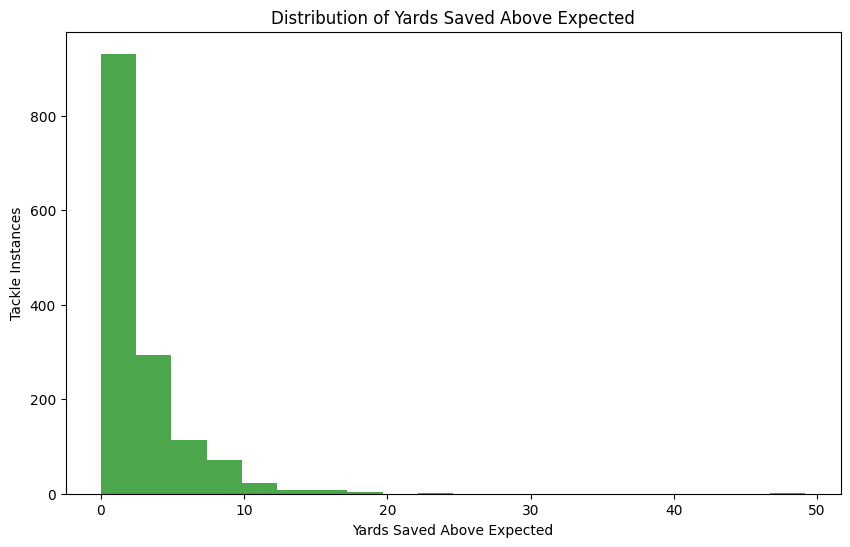

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(week_9_tackles_df['yardsSavedAboveExpected'], bins=20, color='green', alpha=0.7)
plt.xlabel('Yards Saved Above Expected')
plt.ylabel('Tackle Instances')
plt.title('Distribution of Yards Saved Above Expected')
plt.show()

### Permutation Importances

As seen by the permutation importance of the model, the **playType** variable has the most impact on predicting the expected yards gained. It makes sense that this is the case, as pass plays typically allow a team to gain more yards than run plays do. The second greatest impact is from the **distanceFromClosestDefender**, which suggests that the proximity of a defender to a ball carrier or receiver plays a crucial role in determining the expected yards gained.

Insights from permutation importances can contribute to strategic decision-making in football. Coaches can consider the most important factors when devising offensive and defensive strategies based on the expected yards gained.

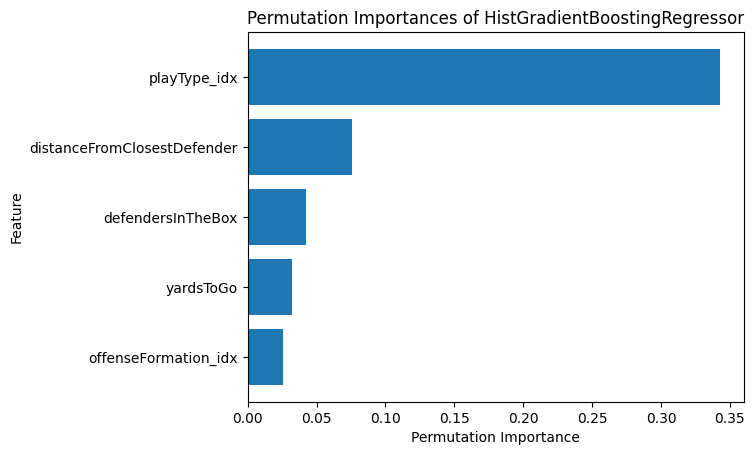

In [11]:
result = permutation_importance(regr, X_train, y_train, n_repeats=10, random_state=42)

feature_importances = result.importances_mean
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)

plt.barh(range(len(feature_importances)), feature_importances[sorted_idx])
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances of HistGradientBoostingRegressor')
plt.show()

## Determining 'yardsAllowedByMissedTackle'

The function **getYardsAllowed** identifies plays with missed tackles during week 9, extracts relevant tracking data, and calculates the yards allowed due to each missed tackle. This function makes the assumption that the point in which the defender is at the position where they are closest to the football, they are also at the position that the missed tackle takes place.

In [12]:
missed_tackles_df = week_9_tackles_df[week_9_tackles_df['pff_missedTackle'] == 1]
missed_tackles_plays = missed_tackles_df[['gameId', 'playId', 'nflId']].drop_duplicates()
missed_tackle_players = missed_tackles_plays['nflId'].drop_duplicates()

week_9_tracking_df = raw_tracking_data[raw_tracking_data['gameId'].isin(week_9_gameIds)]
week_9_tracking_missed_df = week_9_tracking_df[(week_9_tracking_df['nflId'].isin(missed_tackle_players)) | (week_9_tracking_df['club'] == 'football')]

missed_tracking_df = pd.merge(missed_tackles_plays, week_9_tracking_missed_df, on=['gameId', 'playId'], how='left')

def getYardsAllowed(row):
    selected_game_df = games_df[games_df['gameId'] == row['gameId']]
    selected_game = games_df[games_df['gameId'] == row['gameId']]['gameId'].values[0]
    playId = row['playId']
    playerId = row['nflId']
    homeTeam = selected_game_df['homeTeamAbbr'].values[0]
    awayTeam = selected_game_df['visitorTeamAbbr'].values[0]
    missed_tackle_player_tracking_df = missed_tracking_df[(missed_tracking_df['gameId'] == selected_game) & (missed_tracking_df['playId'] == playId) & (missed_tracking_df['nflId_y'] == playerId)]
    missed_tackle_football_tracking_df = missed_tracking_df[(missed_tracking_df['gameId'] == selected_game) & (missed_tracking_df['playId'] == playId) & (missed_tracking_df['displayName'] == 'football')]
    
    min_distance_frameId = None
    min_distance = np.inf

    for index, row in missed_tackle_player_tracking_df.iterrows():
        distances = np.sqrt((missed_tackle_football_tracking_df['x'] - row['x'])**2 + (missed_tackle_football_tracking_df['y'] - row['y'])**2)
        closest_frameId = missed_tackle_football_tracking_df.loc[distances.idxmin(), 'frameId']
        if distances.min() < min_distance:
            min_distance = distances.min()
            min_distance_frameId = closest_frameId
    
    missed_tackle_x_location = missed_tackle_football_tracking_df[missed_tackle_football_tracking_df['frameId'] == min_distance_frameId]['x'].values[0]
    playDirection = missed_tackle_football_tracking_df[missed_tackle_football_tracking_df['frameId'] == min_distance_frameId]['playDirection'].values[0]
    end_of_play_location = missed_tackle_football_tracking_df['x'].iloc[-6]
    
    if playDirection == 'left':
        return round(missed_tackle_x_location - end_of_play_location, 2)
    else:
        return round(end_of_play_location - missed_tackle_x_location, 2)

missed_tackles_df = missed_tackles_df.copy()
missed_tackles_df['yardsAllowedByMissedTackle'] = missed_tackles_df.apply(getYardsAllowed, axis=1)

In [13]:
columns_to_include = ['gameId', 'playId', 'nflId', 'yardsAllowedByMissedTackle']
missed_tackles_df = missed_tackles_df[columns_to_include]

In [14]:
processed_tackles_df = week_9_tackles_df.drop(columns=["ballCarrierId", "yardsToGo", "playResult", "offenseFormation", "defendersInTheBox", "distanceFromClosestDefender", "offenseFormation_idx", "playType_idx", "expectedYards"])
processed_tackles_df = pd.merge(processed_tackles_df, missed_tackles_df, on=['nflId', 'gameId', 'playId'], how='left')
processed_tackles_df.fillna(0, inplace=True)

In [15]:
most_yards_saved = processed_tackles_df.groupby('gameId')['yardsSavedAboveExpected'].idxmax()
most_yards_given_up = processed_tackles_df.groupby('gameId')['yardsAllowedByMissedTackle'].idxmax()

most_yards_saved_df = processed_tackles_df.loc[most_yards_saved, ['gameId', 'playId', 'yardsSavedAboveExpected']]
most_yards_given_up_df = processed_tackles_df.loc[most_yards_given_up, ['gameId', 'playId', 'yardsAllowedByMissedTackle']]

In [16]:
tackle_df = processed_tackles_df[(processed_tackles_df['tackle'] == 1) & (processed_tackles_df['pff_missedTackle'] != 1)]
sum_tackle = tackle_df.groupby('nflId')['yardsSavedAboveExpected'].sum()

assist_df = processed_tackles_df[(processed_tackles_df['assist'] == 1)]
sum_assist = assist_df.groupby('nflId')['yardsSavedAboveExpected'].sum() * 0.5

missed_tackle_df = processed_tackles_df[processed_tackles_df['pff_missedTackle'] == 1]
sum_missed_tackle = missed_tackle_df.groupby('nflId')['yardsAllowedByMissedTackle'].sum()

sum_tackle_reset = sum_tackle.reset_index()
sum_assist_reset = sum_assist.reset_index()
sum_missed_reset = sum_missed_tackle.reset_index()

merged_left = pd.merge(sum_tackle_reset, sum_assist_reset, on='nflId', how='left', suffixes=('_tackle', '_assist'))
merged_right = pd.merge(sum_tackle_reset, sum_assist_reset, on='nflId', how='right', suffixes=('_tackle', '_assist'))

final_sum = pd.concat([merged_left, merged_right], ignore_index=True)
final_sum = pd.merge(final_sum, sum_missed_reset, on='nflId', how='left')
final_sum = final_sum.fillna(0)

final_sum.loc[:, 'yardsSavedAboveExpected_total'] = final_sum['yardsSavedAboveExpected_tackle'] + final_sum['yardsSavedAboveExpected_assist']

In [17]:
sum_columns = ['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']

total_sum = processed_tackles_df.groupby('nflId')[sum_columns].sum().reset_index()
total_sum.columns = ['nflId'] + ['total' + col.title() for col in sum_columns]
total_sum.fillna(0, inplace=True)

total_sum = pd.merge(total_sum, final_sum, on='nflId', how='left')
total_sum = pd.merge(total_sum, players_df[['nflId', 'displayName']], on='nflId', how='left')

In [18]:
unique_team_player_list_df = week_9_tackles_df.groupby('defensiveTeam')['nflId'].agg(list).reset_index()

team_list = []

for index, row in unique_team_player_list_df.iterrows():
    filtered_rows = total_sum[total_sum['nflId'].isin(row['nflId'])]
    filtered_rows = filtered_rows.drop_duplicates()
    
    sum_tackles = filtered_rows['totalTackle'].sum()
    sum_assists = filtered_rows['totalAssist'].sum()
    sum_forced_fumbles = filtered_rows['totalForcedfumble'].sum()
    sum_missed_tackle = filtered_rows['totalPff_Missedtackle'].sum()
    sum_yards_saved = filtered_rows['yardsSavedAboveExpected_tackle'].sum()
    sum_yards_allowed = filtered_rows['yardsAllowedByMissedTackle'].sum()
    
    team_list.append({
        'defensiveTeam': row['defensiveTeam'],
        'teamTotalTackles': sum_tackles,
        'teamTotalAssists': sum_assists,
        'teamTotalForcedFumbles': sum_forced_fumbles,
        'teamTotalMissedTackles': sum_missed_tackle,
        'teamTotalYardsSavedFromTackle': sum_yards_saved,
        'teamTotalYardsAllowed': sum_yards_allowed,
        'averageYardsSavedPerTackle': round(sum_yards_saved / sum_tackles, 2)
    })
    
teams_data_df = pd.DataFrame(team_list)
teams_data_df =teams_data_df.sort_values(by='teamTotalYardsSavedFromTackle', ascending=False)

## Team Total Yards Saved from Tackle

In this data analysis project, the focus was on quantifying the defensive effectiveness of NFL teams. The **yardsSavedAboveExpected** metric, derived using the above machine learning techniques, represents instances where an individual defensive player outperforms expectations on their tackles.

This analysis should go beyond individual player contributions, with a holistic approach that aggregates the **yardsSavedAboveExpected** for each player based on their respective teams. By summing these individual metrics, the study provides a comprehensive evaluation of a team's overall defensive performance and positive impact. This unique perspective allows for a nuanced understanding of how teams collectively excel in limiting the offensive gains beyond what is conventionally expected. 

Exploring the team-level insights derived from this analysis not only sheds light on defensive strengths but also opens avenues for strategic considerations and performance improvements in gameplay. According to the results of the data analysis you can see that in Week 9 of the 2022 NFL season the Indianapolis Colts led the league in total yards saved from tackles with **135.23 yards saved**, whereas the New York Jets had the least yards saved from tackles with **52.2 yards**.

In [19]:
columns = ['defensiveTeam','teamTotalTackles','averageYardsSavedPerTackle','teamTotalYardsSavedFromTackle']
teams_data_df_saved = teams_data_df[columns]
display(teams_data_df_saved.style.background_gradient(axis=0, subset='teamTotalYardsSavedFromTackle'))

,defensiveTeam,teamTotalTackles,averageYardsSavedPerTackle,teamTotalYardsSavedFromTackle
10,IND,40,3.390000,135.680000
1,ATL,35,3.810000,133.420000
13,LA,39,3.270000,127.390000
25,WAS,37,3.310000,122.440000
0,ARI,45,2.530000,113.860000
22,SEA,34,3.340000,113.600000
24,TEN,47,2.340000,109.880000
14,LAC,37,2.940000,108.810000
15,LV,40,2.590000,103.500000
16,MIA,43,2.360000,101.480000


In [20]:
columns = ['defensiveTeam', 'teamTotalMissedTackles', 'teamTotalYardsAllowed']
teams_data_df_allowed = teams_data_df[teams_data_df['teamTotalMissedTackles'] != 0].sort_values(by='teamTotalYardsAllowed', ascending=False)

In [21]:
# CODE SOURCE -- https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays
colors = {
    'ARI':["#97233F","#000000","#FFB612"], 
    'ATL':["#A71930","#000000","#A5ACAF"], 
    'BAL':["#241773","#000000"], 
    'BUF':["#00338D","#C60C30"], 
    'CAR':["#0085CA","#101820","#BFC0BF"], 
    'CHI':["#0B162A","#C83803"], 
    'CIN':["#FB4F14","#000000"], 
    'CLE':["#311D00","#FF3C00"], 
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"], 
    'DET':["#0076B6","#B0B7BC","#000000"], 
    'GB' :["#FFB612","#203731"], 
    'HOU':["#03202F","#A71930"], 
    'IND':["#002C5F","#A2AAAD"], 
    'JAX':["#101820","#D7A22A","#9F792C"], 
    'KC' :["#E31837","#FFB81C"], 
    'LA' :["#003594","#FFA300","#FF8200"], 
    'LAC':["#0080C6","#FFC20E","#FFFFFF"], 
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"], 
    'MIN':["#4F2683","#FFC62F"], 
    'NE' :["#002244","#C60C30","#B0B7BC"], 
    'NO' :["#101820","#D3BC8D"], 
    'NYG':["#0B2265","#A71930","#A5ACAF"], 
    'NYJ':["#125740","#000000","#FFFFFF"], 
    'PHI':["#004C54","#A5ACAF","#ACC0C6"], 
    'PIT':["#FFB612","#101820"], 
    'SEA':["#002244","#69BE28","#A5ACAF"], 
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"], 
    'TEN':["#0C2340","#4B92DB","#C8102E"], 
    'WAS':["#5A1414","#FFB612"], 
    'football':["#CBB67C","#663831"]
}

In [22]:
# CODE SOURCE -- https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays
def hex_to_rgb_array(hex_color):
    '''take in hex val and return rgb np array'''
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))) 

def ColorDistance(hex1,hex2):
    '''d = {} distance between two colors(3)'''
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[1],color_array_2[0]],'football':colors['football']}
    else:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[0],color_array_2[1]],'football':colors['football']}

In [23]:
# CODE SOURCE -- https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays
fig = go.Figure( layout_yaxis_range=[0,53.3], layout_xaxis_range=[0,120])

team_combos = list(set(tracking_data.club.unique())-set(["football"]))
color_orders = ColorPairs(team_combos[0],team_combos[1])

In [24]:
# CODE SOURCE -- https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays
def animate_play(games,tracking_df,play_df,players,gameId,playId):
    selected_game_df = games[games.gameId==gameId].copy()
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    
    # get good color combos
    team_combos = list(set(selected_tracking_df.club.unique())-set(["football"]))
    color_orders = ColorPairs(team_combos[0],team_combos[1])
    
    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    ## Fixing first down marker issue from last year
    if selected_tracking_df.playDirection.values[0] == "right":
        first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    else:
        first_down_marker = line_of_scrimmage - selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add Endzone Colors 
        endzoneColors = {0:color_orders[selected_game_df.homeTeamAbbr.values[0]][0],
                         110:color_orders[selected_game_df.visitorTeamAbbr.values[0]][0]}
        for x_min in [0,110]:
            data.append(
                go.Scatter(
                    x=[x_min,x_min,x_min+10,x_min+10,x_min],
                    y=[0,53.5,53.5,0,0],
                    fill="toself",
                    fillcolor=endzoneColors[x_min],
                    mode="lines",
                    line=dict(
                        color="white",
                        width=3
                        ),
                    opacity=1,
                    showlegend= False,
                    hoverinfo ="skip"
                )
            )
        # Plot Players
        for team in selected_tracking_df.club.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.club==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Player Speed:{} yd/s".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName_x"].values[0],
                                                                                      selected_player_df["s"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=8
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )
    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df.homeTeamAbbr.values[0]
        else:
            angle = 90
            teamName=selected_game_df.visitorTeamAbbr.values[0]
        fig.add_annotation(
            x=x_min+5,
            y=53.5/2,
            text=teamName,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=32,
                color="White"
                ),
            textangle = angle
        )
    return fig

## Most Impactful Play - Yards Saved

In the battleground of NFL Week 9, one defensive play stood out as the epitome of impact, showcasing the prowess of the Los Angeles Chargers' defense. The play, orchestrated by former DPOY Khalil Mack, unfolded with a staggering 47.43 yards saved above expected according to the **yardsSavedAboveExpected** metric. Khalil Mack's tackle on Drake London not only prevented the Atlanta Falcons from reaching their anticipated 8.43 yards but, more significantly, led to a forced fumble. This paved the way for Mack to seize the loose ball and embark on a 44-yard journey down the field.

The Falcons, originally expected to gain at least 5 yards from the completed short pass from Mariota, now found themselves at a deficit of -39 yards. This pivital turnover not only thwarted the Falcon's offensive momentum (and at least a FG attempt) but also handed the Chargers a game-changing opportunity. Although the subsequent Chargers possession ended shortly with an interception on a throw by Justin Herbert, the Chargers ultimately secured a hard-fought victory with a final score of 20 - 17. This shows how a single defensive play, fueled by exceptional individual effort, can reshape the dynamics of a game.

In [25]:
display_impactful_df = week_9_tackles_df[week_9_tackles_df['playId'] ==2183].head(1)
display(display_impactful_df[['gameId', 'playId', 'ballCarrierId', 'playDescription', 'yardsToGo', 'defensiveTeam', 'passResult', 'playResult', 'distanceFromClosestDefender', 'expectedYards', 'yardsSavedAboveExpected']])
animate_play(games_df,week_9_tracking_df,raw_plays_df,players_df,2022110600,2183).show()

,gameId,playId,ballCarrierId,playDescription,yardsToGo,defensiveTeam,passResult,playResult,distanceFromClosestDefender,expectedYards,yardsSavedAboveExpected
2498,2022110600,2183,54473,"(9:31) (No Huddle, Shotgun) M.Mariota pass sho...",2,LAC,C,-39,3.364655,10.19,49.19


## Most Impactful Play - Yards Given Up

On the inverse, the most impactful missed tackle of NFL Week 9 occured in a clash between the Green Bay Packers and the Detroit Lions. The missed tackle by the Lions' Kerby Joseph emerged as the most impactful defensive lapse, as quantified by the **yardsAllowedByMissedTackle** metric. The event unfolded at Frame 46 in the play animation below, as Joseph failed to bring down Aaron Jones upon first contact. The significance of this missed opportunity becomes apparent when considering the hypothetical scenario where a successful tackle by Joseph would have limited Jones to approximately 5 yards from the run.

However, reality painted a different picture. Joseph's missed tackle allowed Jones to surge forward, gaining 4.4 yards before finally being brought to a halt. The repercussions were felt not only in the immediate context of the play but also in the subsequent downs. Had Joseph made the tackle on Jones, the Packers would have faced a 2nd & 5 situation. Instead, the missed opportunity granted the Packers a more favortable 2nd & 1, affording them greater flexibility in their offensive strategy. 

The Packers offense drew up a run for a their next play by AJ Dillon for 6 yards, giving them a 1st down at Detroit's 33 yardline. Ironically, this Packers drive ended with an interception by none other than Kirby Joseph at the Detroit goal, preventing the Packers from scoring at all.

While the ultimate outcome of the game favored the Lions with a 15 - 9 victory, the significance of this missed tackle lies in its potential to be a valuable teaching moment for coaches. The **yardsAllowedByMissedTackle** metric provide aa quantifiable lens through which coaches can dissect defensive errors, offering isnights that extend beyond the game result. It becomes a tool for improvement, allowing adjustments to be made based on a thorough understanding of defensive lapses and their consequences.

In [26]:
display_impactful_df = week_9_tackles_df[week_9_tackles_df['playId'] ==441].head(1)
display(display_impactful_df[['gameId', 'playId', 'ballCarrierId', 'playDescription', 'yardsToGo', 'defensiveTeam', 'passResult', 'playResult', 'distanceFromClosestDefender', 'expectedYards', 'yardsSavedAboveExpected']])
animate_play(games_df,week_9_tracking_df,raw_plays_df,players_df,2022110603,441).show()

,gameId,playId,ballCarrierId,playDescription,yardsToGo,defensiveTeam,passResult,playResult,distanceFromClosestDefender,expectedYards,yardsSavedAboveExpected
2398,2022110603,441,44995,(7:45) A.Jones right end to DET 39 for 9 yards...,10,DET,RUN,9,3.890347,4.22,0.0


## Conclusion

In the world of NFL defensive dynamics, this project aimed to decode the essence of a defense's tackling efforts through data analysis. Focused on the **"Yards Saved Above Expected"** and the repercussions of missed tackles, the exploration offered a panoramic view of team defensive strengths and areas for enhancment. 

This analysis transcends numbers, offering a strategic platform for continuous improvement. Each impactful play underscores the dynamic nature of NFL games, where tackles and missed opportunities become defining moments in the narrative of success. As teams leverage these insights, they embark on a journey of refinement, epitomizing defensive strength in the pursuit of victory on the football field.

## Resources

Credit to Hunter Kempf for the wonderful [Plotly Animated (and interactive) NFL Plays](https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays) code provided, which allowed me to focus on data analysis and not have to worry about creating animated plays myself. It was truly a life saver.

## Acknowledgements

Thank you to the NFL for putting this competition together (and for being the source of my love of sports). A special thanks to Andrew Patton, Ally Blake & Ishani Desai, who I had the pleasure of meeting at the 2023 Women in Sports Data symposium, making me aware of the competition in the first place. 

Also a special thanks to Eric A. Eager and Richard A. Erickson, who recently published their book Football Analytics with Python & R. I found it very helpful in the process of completing this project.

As someone who has worked traditionally in software engineering and building applications and less in data science and analytics, this was an awesome project to work on. I started in September having no idea how to approach the ideas I had in my head, and am very proud of my final solution! It has inspired me to learn more about Machine Learning and create even more insights for sports analytics in future personal projects.

Lastly, thank you to my friends and family who pushed me to finish this despite any discouragements I was feeling over lack of experience and knowledge. You gotta start somewhere!